# Forecasting the All-NBA Team 
## by Chelsea Shu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import ExtraTreesClassifier

# Cleaning the Data

### All-NBA team from 1988-1989 to 2016-2017

This dataset has a list of players who have made the All-NBA team

In [2]:
all_nba = pd.read_csv('All.NBA.1984-2018.csv')
print (all_nba.shape)
all_nba.columns = all_nba.iloc[0]
all_nba = all_nba.drop(0)
all_nba.head()
all_nba.reset_index(0)
all_nba.tail()


(476, 33)


,Rk,Player,Season,Age,Tm,Lg,WS,G,GS,MP,...,BLK,TOV,PF,PTS,FG%,2P%,3P%,eFG%,FT%,TS%
471,471,Carmelo Anthony,2008-09,24,DEN,NBA,5,66,66,2277,...,24,199,195,1504,0.443,0.455,0.371,0.469,0.793,0.532
472,472,Rajon Rondo,2011-12,25,BOS,NBA,4.9,53,53,1957,...,3,193,99,630,0.448,0.464,0.238,0.456,0.597,0.483
473,473,Antonio McDyess,1998-99,24,DEN,NBA,4.2,50,50,1937,...,115,138,175,1061,0.471,0.474,0.111,0.471,0.68,0.515
474,474,Chris Webber,1998-99,25,SAC,NBA,3.6,42,42,1719,...,89,148,145,839,0.486,0.503,0.118,0.488,0.454,0.491
475,475,Bernard King,1990-91,34,WSB,NBA,3.5,64,64,2401,...,16,255,187,1817,0.472,0.478,0.216,0.475,0.79,0.527


#### Cleaning the All-NBA data

In [3]:
string = all_nba['Season'].str[0:2].astype(str) + all_nba['Season'].str[-2:].astype(str)

for i,num in enumerate(string):
    if num == '1900':
        string[i+1] = '2000'

all_nba['Season'] = string.astype(int)
all_nba = all_nba.drop(all_nba[all_nba["Season"] < 1989].index)
all_nba.reset_index(inplace = True)
all_nba.Season = all_nba.Season.astype(int).astype(str)
all_nba.Age = all_nba.Age.astype(int).astype(str)
all_nba.head()
all_nba.shape

(435, 34)

Upon initial glance at the data for all seasons, which is shown below, I notice the dates are listed as a single year. To be consistent, I change the dates in the "all_nba" dataset to be single years. I assign the years to be the second year in the date range.  

In [4]:
#check for null values
all_nba.isnull().sum()
all_nba.head()

,index,Rk,Player,Season,Age,Tm,Lg,WS,G,GS,...,BLK,TOV,PF,PTS,FG%,2P%,3P%,eFG%,FT%,TS%
0,2,2,Michael Jordan,1996,32,CHI,NBA,20.4,82,82,...,42,197,195,2491,0.495,0.506,0.427,0.525,0.834,0.582
1,3,3,LeBron James,2009,24,CLE,NBA,20.3,81,81,...,93,241,139,2304,0.489,0.535,0.344,0.53,0.78,0.591
2,4,4,Michael Jordan,1991,27,CHI,NBA,20.3,82,82,...,83,202,229,2580,0.539,0.551,0.312,0.547,0.851,0.605
3,5,5,David Robinson,1994,28,SAS,NBA,20,80,80,...,265,253,228,2383,0.507,0.51,0.345,0.51,0.749,0.577
4,6,6,Michael Jordan,1989,25,CHI,NBA,19.8,81,81,...,65,290,247,2633,0.538,0.553,0.276,0.546,0.85,0.614


### Player stats data each season from 1988-1989 to 2016-2017

Given that my dataset is from 1950-2017, I select player statistics from 1989-2017. The reason for this is because the 1988-1989 season is the first season where 15 players are selected to the All-NBA team, rather than 10 players. 


In [5]:
season_stats = pd.read_csv("players.csv")


In [6]:
season_stats = pd.read_csv("players.csv")
season_stats = season_stats.drop("Unnamed: 0", axis =1)
indexnames = season_stats[season_stats['Year'] <= 1988.0].index
season_stats = season_stats.drop(indexnames)
season_stats = season_stats.dropna(how = 'all')
season_stats.reset_index(inplace = True)
season_stats = season_stats.drop(columns = 'index')
season_stats.Year = season_stats.Year.astype(int).astype(str)
season_stats.Age = season_stats.Age.astype(int).astype(str)
season_stats.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1989,Kareem Abdul-Jabbar*,C,41,LAL,74.0,74.0,1695.0,12.9,0.511,...,0.739,103.0,231.0,334.0,74.0,38.0,85.0,95.0,196.0,748.0
1,1989,Mark Acres,C,26,BOS,62.0,0.0,632.0,8.2,0.507,...,0.542,59.0,87.0,146.0,19.0,19.0,6.0,23.0,94.0,137.0
2,1989,Michael Adams,PG,26,DEN,77.0,77.0,2787.0,17.5,0.567,...,0.819,71.0,212.0,283.0,490.0,166.0,11.0,180.0,149.0,1424.0
3,1989,Mark Aguirre,SF,29,TOT,80.0,76.0,2597.0,16.4,0.524,...,0.733,146.0,240.0,386.0,278.0,45.0,36.0,208.0,229.0,1511.0
4,1989,Mark Aguirre,SF,29,DAL,44.0,44.0,1529.0,17.3,0.509,...,0.730,90.0,145.0,235.0,189.0,29.0,29.0,140.0,128.0,953.0


Then, I check for null values in the dataset.

In [7]:
#check for null values
season_stats.isnull().sum()

Year          0
Player        0
Pos           0
Age           0
Tm            0
G             0
GS            0
MP            0
PER           5
TS%          73
3PAr         82
FTr          82
ORB%          5
DRB%          5
TRB%          5
AST%          5
STL%          5
BLK%          5
TOV%         59
USG%          5
blanl     15555
OWS           0
DWS           0
WS            0
WS/48         5
blank2    15555
OBPM          0
DBPM          0
BPM           0
VORP          0
FG            0
FGA           0
FG%          82
3P            0
3PA           0
3P%        2773
2P            0
2PA           0
2P%         109
eFG%         82
FT            0
FTA           0
FT%         660
ORB           0
DRB           0
TRB           0
AST           0
STL           0
BLK           0
TOV           0
PF            0
PTS           0
dtype: int64

It seems there are two columns that are completely filled with null values, so I remove those.

In [8]:
#remove blank columns
season_stats.drop(['blanl', 'blank2'], axis = 1, inplace = True)
season_stats.isnull().sum()

Year         0
Player       0
Pos          0
Age          0
Tm           0
G            0
GS           0
MP           0
PER          5
TS%         73
3PAr        82
FTr         82
ORB%         5
DRB%         5
TRB%         5
AST%         5
STL%         5
BLK%         5
TOV%        59
USG%         5
OWS          0
DWS          0
WS           0
WS/48        5
OBPM         0
DBPM         0
BPM          0
VORP         0
FG           0
FGA          0
FG%         82
3P           0
3PA          0
3P%       2773
2P           0
2PA          0
2P%        109
eFG%        82
FT           0
FTA          0
FT%        660
ORB          0
DRB          0
TRB          0
AST          0
STL          0
BLK          0
TOV          0
PF           0
PTS          0
dtype: int64

I notice that PER and USG% (which are both important basketball statistics) each have 5 null values, so I explore further to see if there is a relationship between both of these columns have null values.  It actually turns out that there are null values in USG% and PER for players that did not play any minutes throughout the season. Since they did not play, I can remove them from the data.

In [9]:
#check USAGE and PER because these are important, explore why they are null

null_columns = season_stats.columns[season_stats.isnull().any()]
null_PER = season_stats[season_stats["PER"].isnull()][null_columns]
null_USG = season_stats[season_stats["PER"].isnull()][null_columns]
null_USG.equals(null_PER)



True

In [10]:
#explore why PER is Nan and USG is Nan
season_stats.loc[season_stats['PER'].isnull()]

season_stats = season_stats.drop(season_stats.loc[season_stats['PER'].isnull()].index)
season_stats.isnull().sum()

Year         0
Player       0
Pos          0
Age          0
Tm           0
G            0
GS           0
MP           0
PER          0
TS%         68
3PAr        77
FTr         77
ORB%         0
DRB%         0
TRB%         0
AST%         0
STL%         0
BLK%         0
TOV%        54
USG%         0
OWS          0
DWS          0
WS           0
WS/48        0
OBPM         0
DBPM         0
BPM          0
VORP         0
FG           0
FGA          0
FG%         77
3P           0
3PA          0
3P%       2768
2P           0
2PA          0
2P%        104
eFG%        77
FT           0
FTA          0
FT%        655
ORB          0
DRB          0
TRB          0
AST          0
STL          0
BLK          0
TOV          0
PF           0
PTS          0
dtype: int64

There are some players that have only played a few games or few minutes and they have been able to accumulate stats from their time played in blowout games. This kind of data does not help to predict who gets selected to the All-NBA team, so I will remove any players that played less than 15% of the 82 games in the season and less than 10% of the total minutes in a season. 

In [11]:
season_stats = season_stats[season_stats["G"] >= .15*82]
season_stats = season_stats[season_stats["MP"] > (.1 * 48 * 82)]
season_stats.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1989,Kareem Abdul-Jabbar*,C,41,LAL,74.0,74.0,1695.0,12.9,0.511,...,0.739,103.0,231.0,334.0,74.0,38.0,85.0,95.0,196.0,748.0
1,1989,Mark Acres,C,26,BOS,62.0,0.0,632.0,8.2,0.507,...,0.542,59.0,87.0,146.0,19.0,19.0,6.0,23.0,94.0,137.0
2,1989,Michael Adams,PG,26,DEN,77.0,77.0,2787.0,17.5,0.567,...,0.819,71.0,212.0,283.0,490.0,166.0,11.0,180.0,149.0,1424.0
3,1989,Mark Aguirre,SF,29,TOT,80.0,76.0,2597.0,16.4,0.524,...,0.733,146.0,240.0,386.0,278.0,45.0,36.0,208.0,229.0,1511.0
4,1989,Mark Aguirre,SF,29,DAL,44.0,44.0,1529.0,17.3,0.509,...,0.730,90.0,145.0,235.0,189.0,29.0,29.0,140.0,128.0,953.0


In [12]:
#checking for null values again
season_stats.isnull().sum()

Year         0
Player       0
Pos          0
Age          0
Tm           0
G            0
GS           0
MP           0
PER          0
TS%          0
3PAr         0
FTr          0
ORB%         0
DRB%         0
TRB%         0
AST%         0
STL%         0
BLK%         0
TOV%         0
USG%         0
OWS          0
DWS          0
WS           0
WS/48        0
OBPM         0
DBPM         0
BPM          0
VORP         0
FG           0
FGA          0
FG%          0
3P           0
3PA          0
3P%       1029
2P           0
2PA          0
2P%          0
eFG%         0
FT           0
FTA          0
FT%          0
ORB          0
DRB          0
TRB          0
AST          0
STL          0
BLK          0
TOV          0
PF           0
PTS          0
dtype: int64

I want to explore more why the 3 point percentage is null, so I take a look at the "3P" and "3PA" variables where "3P%" is null. Once I print out the values, I can see that both "3P" and "3PA" are zeros, meaning that "3P%" is zero, but it errors and puts "NaN" because of the division by 0. So in order to fix this, since we know the 3-pointer percentage is 0, we can replace the NaN values with 0.

In [13]:
null_3ppercent = season_stats[season_stats["3P%"].isnull()]

print ("3PA values where 3P% is null",null_3ppercent['3PA'])
print ("3P values where 3P% is null",null_3ppercent['3P'])

3PA values where 3P% is null 28       0.0
40       0.0
43       0.0
47       0.0
52       0.0
53       0.0
61       0.0
79       0.0
92       0.0
93       0.0
101      0.0
123      0.0
139      0.0
140      0.0
141      0.0
176      0.0
196      0.0
197      0.0
208      0.0
210      0.0
217      0.0
276      0.0
287      0.0
301      0.0
345      0.0
348      0.0
369      0.0
376      0.0
402      0.0
407      0.0
        ... 
14702    0.0
14719    0.0
14721    0.0
14808    0.0
14812    0.0
14827    0.0
14884    0.0
14899    0.0
14912    0.0
14936    0.0
14959    0.0
14967    0.0
14984    0.0
14999    0.0
15011    0.0
15046    0.0
15055    0.0
15084    0.0
15085    0.0
15121    0.0
15191    0.0
15192    0.0
15276    0.0
15298    0.0
15360    0.0
15365    0.0
15373    0.0
15398    0.0
15401    0.0
15521    0.0
Name: 3PA, Length: 1029, dtype: float64
3P values where 3P% is null 28       0.0
40       0.0
43       0.0
47       0.0
52       0.0
53       0.0
61       0.0
79       0.0
92    

In [14]:
null_3ppercent = season_stats["3P%"]
null_3ppercent.fillna('0', inplace = True)
#double check the null values
season_stats.isnull().sum()

Year      0
Player    0
Pos       0
Age       0
Tm        0
G         0
GS        0
MP        0
PER       0
TS%       0
3PAr      0
FTr       0
ORB%      0
DRB%      0
TRB%      0
AST%      0
STL%      0
BLK%      0
TOV%      0
USG%      0
OWS       0
DWS       0
WS        0
WS/48     0
OBPM      0
DBPM      0
BPM       0
VORP      0
FG        0
FGA       0
FG%       0
3P        0
3PA       0
3P%       0
2P        0
2PA       0
2P%       0
eFG%      0
FT        0
FTA       0
FT%       0
ORB       0
DRB       0
TRB       0
AST       0
STL       0
BLK       0
TOV       0
PF        0
PTS       0
dtype: int64

Now I want to add a column into the season stats data for whether a player is on the all-NBA team in a given season. To do this I create a unique identifier based on the player's basic information(i.e. name, year, team, and age). I use four columns instead of just using the name to uniquely identify the player because the player's name could show up many times for different seasons of being on the All-NBA team. Then I give players who made the All-NBA team in a given year (this information is from my all_nba table) a 1 and players who did not make the team a 0.  I then output how many all-NBA players in each year to double check that there are 15 in each year.

In [15]:
##creating unique identifier for each unique row
unique = list(season_stats['Year'].astype(str)+season_stats['Player'].str[0:5].astype(str) + season_stats['Tm'].astype(str) + season_stats['Age'].astype(str))
unique_all_nba = list(all_nba['Season'].astype(str)+all_nba['Player'].str[0:5].astype(str) + all_nba['Tm'].astype(str) + all_nba['Age'].astype(str))

season_stats["ID"] = unique
all_nba["ID"]= unique_all_nba

nba_list = []
for i in unique:
    if i in unique_all_nba:
        nba_list.append(1)
    else:
        nba_list.append(0)
        
season_stats["all_nba"] = nba_list

grouped = season_stats.groupby(["Year"]).all_nba.value_counts()
grouped

Year  all_nba
1989  0          301
      1           15
1990  0          317
      1           15
1991  0          308
      1           15
1992  0          303
      1           15
1993  0          301
      1           15
1994  0          310
      1           15
1995  0          325
      1           15
1996  0          377
      1           15
1997  0          363
      1           15
1998  0          369
      1           15
1999  0          296
      1           15
2000  0          337
      1           15
2001  0          368
      1           15
2002  0          350
      1           15
2003  0          346
      1           15
2004  0          402
      1           15
2005  0          404
      1           15
2006  0          375
      1           15
2007  0          357
      1           15
2008  0          383
      1           15
2009  0          383
      1           15
2010  0          388
      1           15
2011  0          428
      1           15
2012  0          367

In [16]:
season_stats[season_stats["Year"] == "1990"][season_stats["Player"] == "Chris Welp"]
season_stats.loc[862, 'all_nba'] =0
season_stats.loc[862]

season_stats[season_stats["Year"] == "2013"][season_stats["Player"] == "James Harden"]
season_stats.loc[12754, 'all_nba'] = 0

grouped = season_stats.groupby(["Year"]).all_nba.value_counts()
grouped


C:\Users\chels\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\chels\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


Year  all_nba
1989  0.0        301
      1.0         15
1990  0.0        317
      1.0         15
1991  0.0        308
      1.0         15
1992  0.0        303
      1.0         15
1993  0.0        301
      1.0         15
1994  0.0        310
      1.0         15
1995  0.0        325
      1.0         15
1996  0.0        377
      1.0         15
1997  0.0        363
      1.0         15
1998  0.0        369
      1.0         15
1999  0.0        296
      1.0         15
2000  0.0        337
      1.0         15
2001  0.0        368
      1.0         15
2002  0.0        350
      1.0         15
2003  0.0        346
      1.0         15
2004  0.0        402
      1.0         15
2005  0.0        404
      1.0         15
2006  0.0        375
      1.0         15
2007  0.0        357
      1.0         15
2008  0.0        383
      1.0         15
2009  0.0        383
      1.0         15
2010  0.0        388
      1.0         15
2011  0.0        428
      1.0         15
2012  0.0        367

In [17]:
##adding a column for if a player made the all-nba team the previous year
season_stats["last_year"] = 0

for player in season_stats["Player"]:
    b = season_stats[season_stats["Player"]== player][season_stats["all_nba"] == 1]["Year"]
    a = season_stats[season_stats["Player"]== player]["Year"]

    for i in a.index:
        if (str(int(a[i])-1)) in b.values:
            season_stats.loc[i, "last_year"] = 1
        else:
            season_stats.loc[i, "last_year"] = 0

season_stats.head()


C:\Users\chels\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,TRB,AST,STL,BLK,TOV,PF,PTS,ID,all_nba,last_year
0,1989,Kareem Abdul-Jabbar*,C,41,LAL,74.0,74.0,1695.0,12.9,0.511,...,334.0,74.0,38.0,85.0,95.0,196.0,748.0,1989KareeLAL41,0.0,0
1,1989,Mark Acres,C,26,BOS,62.0,0.0,632.0,8.2,0.507,...,146.0,19.0,19.0,6.0,23.0,94.0,137.0,1989Mark BOS26,0.0,0
2,1989,Michael Adams,PG,26,DEN,77.0,77.0,2787.0,17.5,0.567,...,283.0,490.0,166.0,11.0,180.0,149.0,1424.0,1989MichaDEN26,0.0,0
3,1989,Mark Aguirre,SF,29,TOT,80.0,76.0,2597.0,16.4,0.524,...,386.0,278.0,45.0,36.0,208.0,229.0,1511.0,1989Mark TOT29,0.0,0
4,1989,Mark Aguirre,SF,29,DAL,44.0,44.0,1529.0,17.3,0.509,...,235.0,189.0,29.0,29.0,140.0,128.0,953.0,1989Mark DAL29,0.0,0


In [18]:
#hard coding that these ten players made it the year before because we do not have data in our dataset about 1988
players_1988 = ["Charles Barkley*", "Larry Bird*","Hakeem Olajuwon*", "Michael Jordan*",  "Magic Johnson*", "Karl Malone*",
               "Dominique Wilkins*","Patrick Ewing*", "John Stockton*", "Clyde Drexler*"]
for p in players_1988:
    row = season_stats[season_stats["Player"]== p][season_stats["Year"] == "1989"].index
    for j in row:
        season_stats.loc[j, 'last_year'] = 1
season_stats.head()


C:\Users\chels\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,TRB,AST,STL,BLK,TOV,PF,PTS,ID,all_nba,last_year
0,1989,Kareem Abdul-Jabbar*,C,41,LAL,74.0,74.0,1695.0,12.9,0.511,...,334.0,74.0,38.0,85.0,95.0,196.0,748.0,1989KareeLAL41,0.0,0
1,1989,Mark Acres,C,26,BOS,62.0,0.0,632.0,8.2,0.507,...,146.0,19.0,19.0,6.0,23.0,94.0,137.0,1989Mark BOS26,0.0,0
2,1989,Michael Adams,PG,26,DEN,77.0,77.0,2787.0,17.5,0.567,...,283.0,490.0,166.0,11.0,180.0,149.0,1424.0,1989MichaDEN26,0.0,0
3,1989,Mark Aguirre,SF,29,TOT,80.0,76.0,2597.0,16.4,0.524,...,386.0,278.0,45.0,36.0,208.0,229.0,1511.0,1989Mark TOT29,0.0,0
4,1989,Mark Aguirre,SF,29,DAL,44.0,44.0,1529.0,17.3,0.509,...,235.0,189.0,29.0,29.0,140.0,128.0,953.0,1989Mark DAL29,0.0,0


In [19]:
#making labels_list with how many all_nbas they get in lifetime
new = season_stats.sort_values(by=['Player', "Age"])
labels_list = []
data_list = []
unique_players = new["Player"].drop_duplicates()
new_df = pd.DataFrame()
for i in unique_players:
    labels_list.append(len(new[new["Player"] == i][new["all_nba"] == 1]))
    new_df = new_df.append(new[new['Player'] == i])

C:\Users\chels\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [20]:
new_df.drop(new_df[new_df['Tm'] == 'TOT'].index, inplace = True) 
new_df.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,TRB,AST,STL,BLK,TOV,PF,PTS,ID,all_nba,last_year
134,1989,A.C. Green,PF,25,LAL,82.0,82.0,2510.0,17.8,0.594,...,739.0,103.0,94.0,55.0,119.0,172.0,1088.0,1989A.C. LAL25,0.0,0
579,1990,A.C. Green,PF,26,LAL,82.0,82.0,2709.0,14.7,0.548,...,712.0,90.0,66.0,50.0,116.0,207.0,1061.0,1990A.C. LAL26,0.0,0
1056,1991,A.C. Green,PF,27,LAL,82.0,21.0,2164.0,13.8,0.556,...,516.0,71.0,59.0,23.0,99.0,117.0,750.0,1991A.C. LAL27,0.0,0
1506,1992,A.C. Green,PF,28,LAL,82.0,53.0,2902.0,16.7,0.556,...,762.0,117.0,91.0,36.0,111.0,141.0,1116.0,1992A.C. LAL28,0.0,0
1948,1993,A.C. Green,PF,29,LAL,82.0,55.0,2819.0,16.3,0.603,...,711.0,116.0,88.0,39.0,116.0,149.0,1051.0,1993A.C. LAL29,0.0,0


I have done a lot of data cleaning, so here is my final dataset that I will be using. It has statistics for every player from 1989 to 2017 and includes a column for whether they made the All-NBA team  in a particular year or not. 

In [21]:
season_stats = new_df
season_stats.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,TRB,AST,STL,BLK,TOV,PF,PTS,ID,all_nba,last_year
134,1989,A.C. Green,PF,25,LAL,82.0,82.0,2510.0,17.8,0.594,...,739.0,103.0,94.0,55.0,119.0,172.0,1088.0,1989A.C. LAL25,0.0,0
579,1990,A.C. Green,PF,26,LAL,82.0,82.0,2709.0,14.7,0.548,...,712.0,90.0,66.0,50.0,116.0,207.0,1061.0,1990A.C. LAL26,0.0,0
1056,1991,A.C. Green,PF,27,LAL,82.0,21.0,2164.0,13.8,0.556,...,516.0,71.0,59.0,23.0,99.0,117.0,750.0,1991A.C. LAL27,0.0,0
1506,1992,A.C. Green,PF,28,LAL,82.0,53.0,2902.0,16.7,0.556,...,762.0,117.0,91.0,36.0,111.0,141.0,1116.0,1992A.C. LAL28,0.0,0
1948,1993,A.C. Green,PF,29,LAL,82.0,55.0,2819.0,16.3,0.603,...,711.0,116.0,88.0,39.0,116.0,149.0,1051.0,1993A.C. LAL29,0.0,0


# Exploratory Analysis

#### Age and Player Efficiency

Because of the nature of basketball and aging, I suspect that there might be a relationship between age and how efficient a player is. I suspect that while players are young, their performance will get better and better, but once they've reached their peak age, their performance will start to decrease. I will explore that below. To measure, I will plot the relationshp between age and PER, which is a measure of the player's performance.

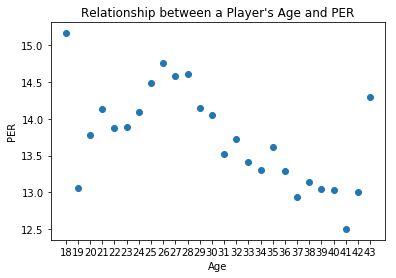

In [22]:
#checking age and PER
x = []
y = []
for i in sorted(season_stats.Age.unique()):
    year = season_stats[season_stats.Age == i]
    per = np.mean(year['PER'])
    
    x.append(i)
    y.append(per)
plt.scatter(x,y)
plt.xlabel("Age")
plt.ylabel("PER")
plt.title("Relationship between a Player's Age and PER")
plt.show()

As we can see from this graph, player performance increases until a peak age of 26, and then it decreases steadily after that.

#### Payer Efficiency and Other Features

I want to check what other features are correlated with high performance. I suspect that points, assists, rebounds, and win shares will be highly correlated with PER because the more of these metrics a player has, the more likely they perform well. Let's explore. 

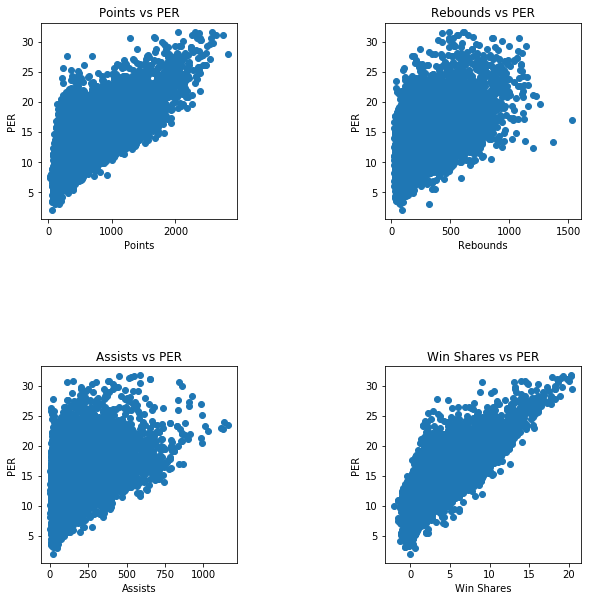

In [23]:

fig,ax = plt.subplots(2, 2, figsize = (15,15))   #subplots
ax = ax.flatten()
        
ax[0].scatter(season_stats.PTS, season_stats.PER)
ax[0].set_title("Points vs PER")
ax[0].set_xlabel("Points")
ax[0].set_ylabel("PER")

ax[1].scatter(season_stats.TRB, season_stats.PER)
ax[1].set_title("Rebounds vs PER")
ax[1].set_xlabel("Rebounds")
ax[1].set_ylabel("PER")

ax[2].scatter(season_stats.AST, season_stats.PER)
ax[2].set_title("Assists vs PER")
ax[2].set_xlabel("Assists")
ax[2].set_ylabel("PER")

ax[3].scatter(season_stats.WS, season_stats.PER)
ax[3].set_title("Win Shares vs PER")
ax[3].set_xlabel("Win Shares")
ax[3].set_ylabel("PER")

plt.subplots_adjust(left=.5, bottom=.5, right=1, top=1, wspace=.75, hspace=.75)


My graphs confirm my suspicions. Each of these variables has a positive correlation with the player's efficiency rating. 

### Feature Importance

In order to have the most accurate model, I want to pick features that contribute most to whether someone makes the All-NBA team or not.  Looking at the columns, I notice that there are columns that are calculated from other columns (i.e. Free throw percentage (FT%) is equal to the column FT (free throws) divided by FTA (free throw attempts)). Having all three columns there seems repetitive so I will take certain columns out and leave just the percentage columns, since they capture the amount of attempts as well as successful attempts. I also remove redundant columns like WS (win shares) and WS/48.  I aso notice that some columns serve purposes for only certain player positions (i.e. DRB (defensive rebounds) would not be a strong statistic for offensive player positions), so I will drop these columns and keep the column that captures the total (i.e. Total Rebounds). Removing these columns will allow my model to be the best predictive model. 

Because I want to determine the All-NBA team based on players' abilities, I will remove two columns, Value Over Replacement Player (VORP) and Box Plus/Minus (BPM). The reason for removing these columns is because these statistics are not statistics that directly describe the player's direct statistics from playing games in the NBA. Rather, they are metrics that describe a player's value. This can introduce problems because this metric can be calculated in a way that does not objectively describe the player. 

Additionally, I also use certain features such as Age and whether a player made the All-NBA team the previous year. I suspect that players that made the team the year before are more likely to make the team again, so I want to explore if this is an important feature in predicting who makes the All-NBA team..

I then explore the top ten columns that contribute the most to who make the All-NBA team.

C:\Users\chels\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


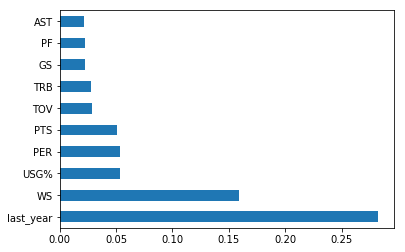

last_year    0.282567
WS           0.158795
USG%         0.053906
PER          0.053534
PTS          0.050931
TOV          0.028511
TRB          0.027998
GS           0.022636
PF           0.022391
AST          0.022075
dtype: float64


In [24]:
model = ExtraTreesClassifier()
columns = ['Age', 'G', 'GS', 'MP', 'PER', 'TS%',
       '3PAr', 'FTr', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%',  'WS',  
       'FG%',  '3P%',  '2P%', 'eFG%',
       'FT%',  'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'last_year']
model.fit(season_stats[columns],season_stats['all_nba'])
#plot graph of feature importances
feat_importances = pd.Series(model.feature_importances_, index=season_stats[columns].columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()
print (feat_importances.nlargest(10))

As we can see from our bar plot, making the All-NBA team the previous year is a very important feature in determining who makes the team. Other statistics that contribute to predicting the All-NBA team are player efficiency (PER), points, win shares, rebounds, etc. 

I will use these ten columns in my model. It is important to note that while other features such as age may seem like they correlate with whether a player makes the All-NBA team (because as a player gets older, they play worse), the differences in how players perform when they are older are reflected in their player statistics (i.e. points, rebounds, etc). For that reason, age does not contribute much to predicting the All-NBA team, but rather other statistics do. 

# Random Forest Algorithm

Because of the nature of basketball, player statistics are season-dependent. For this reason, I decide to split my test and train data using backtesting. I train my model on two seasons and predict for the following season for every season from 1989 until 2017. For example, I might train my data on the 2007 and 2008 seasons, and I will test on the 2009 season. 

Within the All-NBA team, there are three tiers of teams, each with 1 guard, 2 forwards, and 2 centers, meaning that there are 3 guards, 6 forwards, and 6 centers that are on the All-NBA team. After my model predicts probabilities that each player will make the team, I choose the 3 guards, 6 forwards, and 6 centers with the highest probabilities of making the team. 
    

In [25]:
feature = ['GS', 'MP', 'PER', 'USG%',  'WS', 'TRB', 'AST',  'TOV', 'PTS', 'last_year']

for i in sorted(season_stats.Year.unique())[0:-2]:
    season_train_data = season_stats[season_stats.Year == i]
    season_train_data = season_train_data.append(season_stats[season_stats.Year ==  str(int(i)+1)])
    train_data = season_train_data[feature]
    
    season_test_data = season_stats[season_stats.Year == str(int(i)+2)]
    season_test_data = season_test_data.replace({'PG': 'G','SG':'G','PF':'F', "SF": 'F', 'PF-C': 'F'})
    season_test_data = season_test_data.sort_values(by=['Pos'])
    test_data = season_test_data[feature]

    test_labels = season_test_data['all_nba']
    train_labels = season_stats[season_stats.Year == i]['all_nba']
    train_labels = train_labels.append(season_stats[season_stats.Year == str(int(i)+1)]['all_nba'])
  
    f1 = []
    f1_1 = []
    f1_0 = []
    RF = RandomForestClassifier(n_estimators =100, max_depth = 2, random_state = 0)
    RF.fit(train_data, train_labels)

    predicted_prob=RF.predict_proba(test_data)
    season_test_data['predicted_prob'] = predicted_prob[:,1]

    #predicted labels based on position restraints
    team = []
    for i in season_test_data.Pos.unique():
        if i == 'C':
            pos = season_test_data[season_test_data['Pos']  == i]
            largest=pos.nlargest(3, ['predicted_prob'])['Player'].tolist()

        else:
            pos = season_test_data[season_test_data['Pos']  == i]
            largest  = pos.nlargest(6, ['predicted_prob'])["Player"].tolist()
        for i in range(len(largest)):
            team.append(largest[i])
    
    test_predicted_labels = []
    for p in season_test_data.Player:

        if p in team:
            test_predicted_labels.append(1)
        else:
            test_predicted_labels.append(0)
    f1.append(f1_score(season_test_data['all_nba'], test_predicted_labels,  average = 'weighted'))
    f1_1.append(f1_score(season_test_data['all_nba'], test_predicted_labels, pos_label =1, average = 'binary'))
    f1_0.append(f1_score(season_test_data['all_nba'], test_predicted_labels, pos_label = 0, average = 'binary'))

print ("Weighted accuracy: " + str(np.mean(f1)))
print ("Accuracy of classifing who did NOT make the All-NBA team: " + str(np.mean(f1_0)))  
print ("Accuracy of classifying who did make the All-NBA team: " + str(np.mean(f1_1)))

Weighted accuracy: 0.9844559585492227
Accuracy of classifing who did NOT make the All-NBA team: 0.9919137466307277
Accuracy of classifying who did make the All-NBA team: 0.8000000000000002


As we can see, when the model predicts who does not make the team, it does so with 99% accuracy. However, when it predicts who will make the All-NBA team, it predicts with 80% accuracy. The reason for this is because there are only 15 players each year that get picked to the All-NBA team. Therefore, if the model misclassifies even just one or two players, the accuracy drops immensely. 

Overall, the model does a great job. It classifies whether players will make the All-NBA team or not correctly 98.4% of the time.